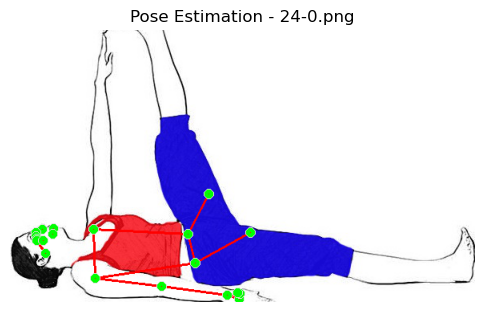

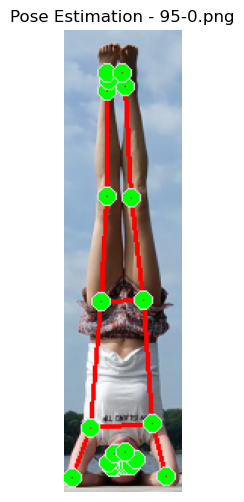

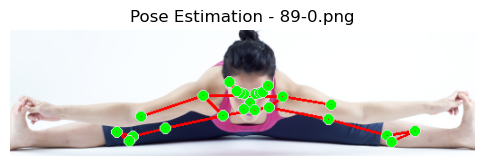

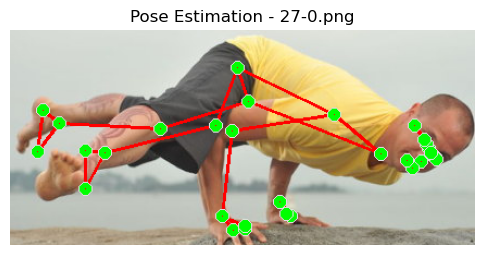

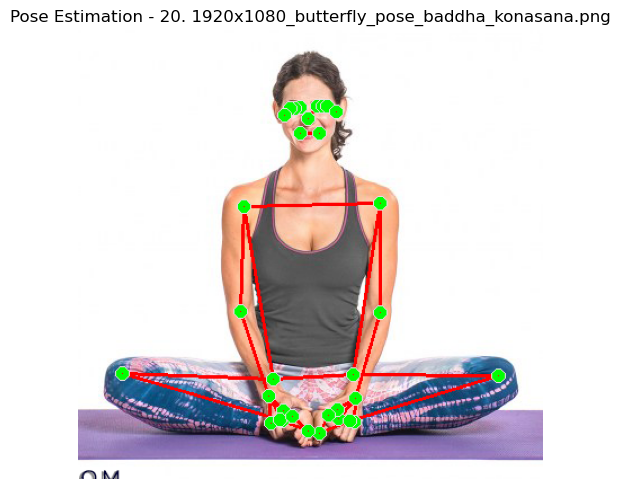

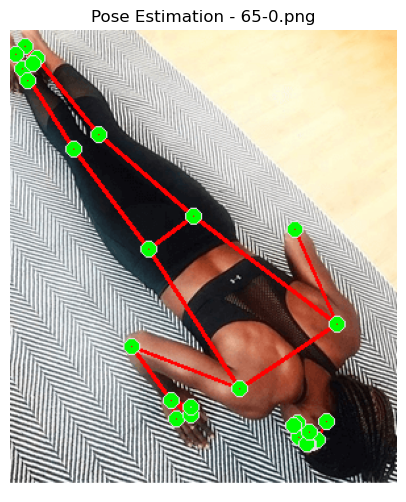

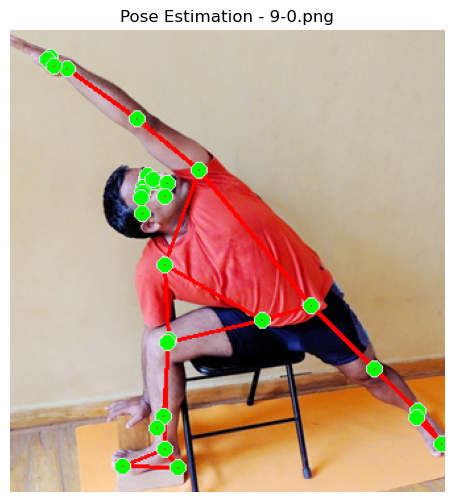

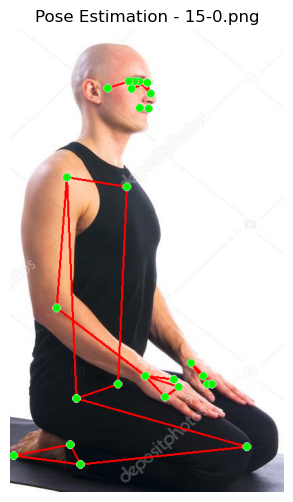

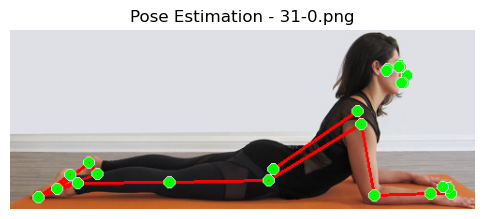

In [16]:
import os
import cv2
import random
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

#Paso1
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

#Paso2
dataset_folder = "dataset"
all_images = []
for pose_folder in os.listdir(dataset_folder):
    pose_path = os.path.join(dataset_folder, pose_folder)
    if os.path.isdir(pose_path):
        images = [os.path.join(pose_path, img) for img in os.listdir(pose_path) if img.endswith(('.jpg', '.png'))]
        all_images.extend(images)
#Paso3
selected_images = random.sample(all_images, 10)

#Paso4
for img_path in selected_images:
    image = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)
    
    #Paso5
    if results.pose_landmarks:
        annotated_image = image_rgb.copy()
        mp_drawing.draw_landmarks(
            annotated_image,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=3, circle_radius=3),
            connection_drawing_spec=mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2)
        )
        plt.figure(figsize=(6, 6))
        plt.imshow(annotated_image)
        plt.title(f'Pose Estimation - {os.path.basename(img_path)}')
        plt.axis('off')
        plt.show()
#Paso6
pose.close()


In [2]:
'''
-Paso 1: Inicialización del Modelo MediaPipe Pose
Se crea un objeto Pose de MediaPipe, que detectará los puntos clave del cuerpo en cada imagen.
static_image_mode=True: Indica que se procesan imágenes individuales.
min_detection_confidence=0.5: Establece la confianza mínima para detectar la pose.
También se define mp_drawing para dibujar el esqueleto sobre la imagen.

-Paso 2: Obtener Todas las Imágenes del Dataset
El código recorre todas las carpetas dentro de dataset/, verifica que realmente sean carpetas y almacena las rutas de todas las imágenes en una lista (all_images).

-Paso 3: Seleccionar 10 Imágenes Aleatorias
Si hay más de 10 imágenes disponibles, se eligen 10 aleatoriamente con random.sample(). Si hay menos, se seleccionan todas.

-Paso 4: Procesar Cada Imagen Seleccionada
Para cada imagen:
    Se carga con cv2.imread().
    Se convierte a formato RGB (cv2.COLOR_BGR2RGB) para que MediaPipe pueda procesarla correctamente.
    Se usa pose.process(image_rgb), que devuelve una lista de puntos clave si se detecta una persona en la imagen.

-Paso 5: Dibujar el Esqueleto Sobre la Imagen
Si se detecta una pose:
    Se copian los datos de la imagen original.
    Se dibujan los puntos clave en verde.
    Se dibujan las conexiones entre puntos (brazos, piernas, torso) en rojo.

-Paso 6: Cerrar el Modelo de MediaPipe
Al finalizar, se libera el modelo con pose.close().
'''

'\n-Paso 1: Inicialización del Modelo MediaPipe Pose\nSe crea un objeto Pose de MediaPipe, que detectará los puntos clave del cuerpo en cada imagen.\nstatic_image_mode=True: Indica que se procesan imágenes individuales.\nmin_detection_confidence=0.5: Establece la confianza mínima para detectar la pose.\nTambién se define mp_drawing para dibujar el esqueleto sobre la imagen.\n\n-Paso 2: Obtener Todas las Imágenes del Dataset\nEl código recorre todas las carpetas dentro de dataset/, verifica que realmente sean carpetas y almacena las rutas de todas las imágenes en una lista (all_images).\n\n-Paso 3: Seleccionar 10 Imágenes Aleatorias\nSi hay más de 10 imágenes disponibles, se eligen 10 aleatoriamente con random.sample(). Si hay menos, se seleccionan todas.\n\n-Paso 4: Procesar Cada Imagen Seleccionada\nPara cada imagen:\n    Se carga con cv2.imread().\n    Se convierte a formato RGB (cv2.COLOR_BGR2RGB) para que MediaPipe pueda procesarla correctamente.\n    Se usa pose.process(image_rgb)

In [1]:
import os
import cv2
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.spatial import distance
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2

# Cargar el modelo MoveNet
interpreter = tf.lite.Interpreter(model_path="movenet_thunder.tflite")
interpreter.allocate_tensors()

def detectar_keypoints(image):
    img = cv2.resize(image, (192, 192))
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)
    
    input_tensor_index = interpreter.get_input_details()[0]['index']
    output_tensor_index = interpreter.get_output_details()[0]['index']
    
    interpreter.set_tensor(input_tensor_index, img)
    interpreter.invoke()
    keypoints = interpreter.get_tensor(output_tensor_index)[0][0]
    return keypoints

def procesar_imagen(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    keypoints = detectar_keypoints(image_rgb)
    return image_rgb, keypoints

def construir_dataset():
    dataset_folder = "dataset"
    pose_data = {}
    
    for pose_folder in os.listdir(dataset_folder):
        pose_path = os.path.join(dataset_folder, pose_folder)
        if os.path.isdir(pose_path):
            images = [os.path.join(pose_path, img) for img in os.listdir(pose_path) if img.endswith(('.jpg', '.png'))]
            if images:
                img_path = random.choice(images)
                _, keypoints = procesar_imagen(img_path)
                if keypoints is not None:
                    pose_data[pose_folder] = keypoints.flatten()
    return pose_data

def detectar_pose(keypoints, pose_names):
    vector_pose = keypoints.flatten()
    min_dist = float('inf')
    mejor_pose = "Desconocida"
    
    for pose_name, ref_vector in pose_names.items():
        dist = distance.euclidean(vector_pose, ref_vector)
        if dist < min_dist:
            min_dist = dist
            mejor_pose = pose_name
    
    return mejor_pose

pose_reference = construir_dataset()
selected_images = random.sample(
    sum([[os.path.join("dataset", folder, img) for img in os.listdir(os.path.join("dataset", folder)) if img.endswith(('.jpg', '.png'))] for folder in os.listdir("dataset") if os.path.isdir(os.path.join("dataset", folder))], []),
    10
)

for img_path in selected_images:
    processed_img, keypoints = procesar_imagen(img_path)
    pose_name = detectar_pose(keypoints, pose_reference) if keypoints is not None else "No detectado"
    
    plt.figure(figsize=(6, 6))
    plt.imshow(processed_img)
    plt.title(f'Pose: {pose_name}')
    plt.axis('off')
    plt.show()


ImportError: DLL load failed while importing defs: No se encontró el proceso especificado.

In [4]:
!pip install tensorflow

^C
